# Importation des librairies utiles

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pycolfits
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
from tqdm.notebook import trange
from  matplotlib.colors import LogNorm
from copy import deepcopy

In [2]:
%matplotlib inline

In [3]:
def flag_results(data):
    flag_nan, = np.where((np.isnan(data['SERSIC_GALFIT'])) | (np.isnan(data['ELLIPTICITYERR_GALFIT'])) | (np.isnan(data['ARERR_GALFIT'])) 
                         | (np.isnan(data['REERR_GALFIT'])) | (np.isnan(data['MAGERR_GALFIT'])))
    mask_nan=np.ones(len(data['FIT_DONE']),bool)
    mask_nan[flag_nan]=0
    flag_all,=np.where(mask_nan==True)
    flag_bad,=np.where((data['SERSIC_GALFIT']==0.2) | (data['SERSIC_GALFIT']==20.) | (data['REERR_GALFIT']==99999) | (data['RE_GALFIT']==400) ) 
    mask_bad=np.ones(len(data['FIT_DONE']),bool)
    mask_bad[flag_bad]=0
    flag_good,=np.where(data['FLAGS_GALFIT']=='GOOD')
    mask_good=np.ones(len(data['FIT_DONE']),bool)
    mask_good[flag_good]=0
    mask_bad_nan=mask_bad&mask_nan
    flag_all_m_b, = np.where(mask_bad_nan==True)
    
    good,=np.where((mask_bad&mask_nan&np.logical_not(mask_good))==True)
    suspisious,=np.where((mask_bad&mask_nan&mask_good)==True)
    bad,=np.where((np.logical_not(mask_bad)&mask_nan)==True)
    non_exist,=np.where(np.logical_not(mask_nan))
    return good, suspisious, bad, non_exist

In [4]:
def flag_results_m80(data,mag80):
    flag_nan, = np.where((np.isnan(data['SERSIC_GALFIT'])) | (np.isnan(data['ELLIPTICITYERR_GALFIT'])) | (np.isnan(data['ARERR_GALFIT'])) 
                         | (np.isnan(data['REERR_GALFIT'])) | (np.isnan(data['MAGERR_GALFIT'])))
    mask_nan=np.ones(len(data['FIT_DONE']),bool)
    mask_nan[flag_nan]=0
    flag_all,=np.where(mask_nan==True)
    flag_bad,=np.where((data['SERSIC_GALFIT']==0.2) | (data['SERSIC_GALFIT']==20.) | (data['REERR_GALFIT']==99999) | (data['RE_GALFIT']==400) | (data['MAG_BEST']>mag80) )
    mask_bad=np.ones(len(data['FIT_DONE']),bool)
    mask_bad[flag_bad]=0
    flag_good,=np.where(data['FLAGS_GALFIT']=='GOOD')
    mask_good=np.ones(len(data['FIT_DONE']),bool)
    mask_good[flag_good]=0
    mask_bad_nan=mask_bad&mask_nan
    flag_all_m_b, = np.where(mask_bad_nan==True)
    
    good,=np.where((mask_bad&mask_nan&np.logical_not(mask_good))==True)
    suspisious,=np.where((mask_bad&mask_nan&mask_good)==True)
    bad,=np.where((np.logical_not(mask_bad)&mask_nan)==True)
    non_exist,=np.where(np.logical_not(mask_nan))
    return good, suspisious, bad, non_exist

In [5]:
def extract_value(ldata,val,flag) : 
    evalu = np.array([])
    for i in range(len(ldata)) :
        data=ldata[i]
        evalu=np.concatenate((evalu,data[val][flag[i]]))
    return evalu

In [6]:
def extract_value_all(ldata,val) : 
    evalu = np.array([])
    for i in range(len(ldata)) :
        data=ldata[i]
        evalu=np.concatenate((evalu,data[val]))
    return evalu

# Disque 

## catalogue 

In [7]:
lcombcat=["combcat1800_1_disk_nf.fits",
          "combcat1800_2_disk_nf.fits",
          "combcat1800_3_disk_nf.fits",
          "combcat1800_4_disk_nf.fits",
          "combcat1800_5_disk_nf.fits",
          "combcat1800_6_disk_nf.fits",
          "combcat1800_7_disk_nf.fits"]

In [8]:
ldata=[]
for i in range(len(lcombcat)) : 
    disk = fits.open(lcombcat[i])
    data_disk=disk[1].data
    ldata.append(data_disk)

In [9]:
lgood, lsusp, lbad, lnan = [],[], [], []
for data in ldata :
    g,s,b,n = flag_results(data)
    lgood.append(g)
    lsusp.append(s)
    lbad.append(b)
    lnan.append(n)

gs = []
bn = []

for i in range(len(lgood)):
    gs.append(np.concatenate((lgood[i],lsusp[i])))
    bn.append(np.concatenate((lbad[i],lnan[i])))

In [10]:
lgood, lsusp, lbad, lnan = [],[], [], []
for data in ldata :
    g,s,b,n = flag_results_m80(data,21.3)
    lgood.append(g)
    lsusp.append(s)
    lbad.append(b)
    lnan.append(n)
    
for i in range(len(lgood)):
    gs.append(np.concatenate((lgood[i],lsusp[i])))
    bn.append(np.concatenate((lbad[i],lnan[i])))

In [10]:
limage=["/local/home/fs269899/stage/egg_jwst/PRIMER/MIRI/f1800w/img1/egg-20220422-jwst-f1800w-sci_disk_adu.fits",
        "/local/home/fs269899/stage/egg_jwst/PRIMER/MIRI/f1800w/img2/egg-20220512-jwst-f1800w-sci_disk_adu.fits",
        "/local/home/fs269899/stage/egg_jwst/PRIMER/MIRI/f1800w/img3/egg-20220512-jwst-f1800w-sci_disk_adu.fits",
        "/local/home/fs269899/stage/egg_jwst/PRIMER/MIRI/f1800w/img4/egg-20220513-jwst-f1800w-sci_disk_adu.fits",
        "/local/home/fs269899/stage/egg_jwst/PRIMER/MIRI/f1800w/img5/egg-20220513-jwst-f1800w-sci_disk_adu.fits",
        "/local/home/fs269899/stage/egg_jwst/PRIMER/MIRI/f1800w/img6/egg-20220513-jwst-f1800w-sci_disk_adu.fits",
        "/local/home/fs269899/stage/egg_jwst/PRIMER/MIRI/f1800w/img7/egg-20220513-jwst-f1800w-sci_disk_adu.fits"]

In [11]:
lcatEGG=["/local/home/fs269899/stage/egg_jwst/PRIMER/MIRI/f1800w/img1/egg-20220422.fits",
         "/local/home/fs269899/stage/egg_jwst/PRIMER/MIRI/f1800w/img2/egg-20220512.fits",
         "/local/home/fs269899/stage/egg_jwst/PRIMER/MIRI/f1800w/img3/egg-20220512.fits",
         "/local/home/fs269899/stage/egg_jwst/PRIMER/MIRI/f1800w/img4/egg-20220513.fits",
         "/local/home/fs269899/stage/egg_jwst/PRIMER/MIRI/f1800w/img5/egg-20220513.fits",
         "/local/home/fs269899/stage/egg_jwst/PRIMER/MIRI/f1800w/img6/egg-20220513.fits",
         "/local/home/fs269899/stage/egg_jwst/PRIMER/MIRI/f1800w/img7/egg-20220513.fits"]

In [12]:
tot=0
ng = 0
ns = 0
for data in ldata :
    print(data['FIT_DONE'].shape[0])
    tot=tot+data['FIT_DONE'].shape[0]
    
for i in range(len(lgood)):
    ng = ng + lgood[i].shape[0]
    ns = ns + lsusp[i].shape[0]
print("total: ",tot,", avec",ng,"good et",ns,"suspicieux")

2062
2212
2202
2226
2158
2127
2120
total:  15107 , avec 7862 good et 2810 suspicieux


In [13]:
tot=0
ng = 0
ns = 0
for data in ldata :
    #print(data['FIT_DONE'].shape[0])
    tot=tot+data['FIT_DONE'].shape[0]
    
for i in range(len(lgood)):
    ng = ng + gs[i].shape[0]
    ns = ns + bn[i].shape[0]
print("gs: ",ng/tot,", bad",ns/tot)

gs:  0.7064274839478387 , bad 0.2935725160521612


## Mag 

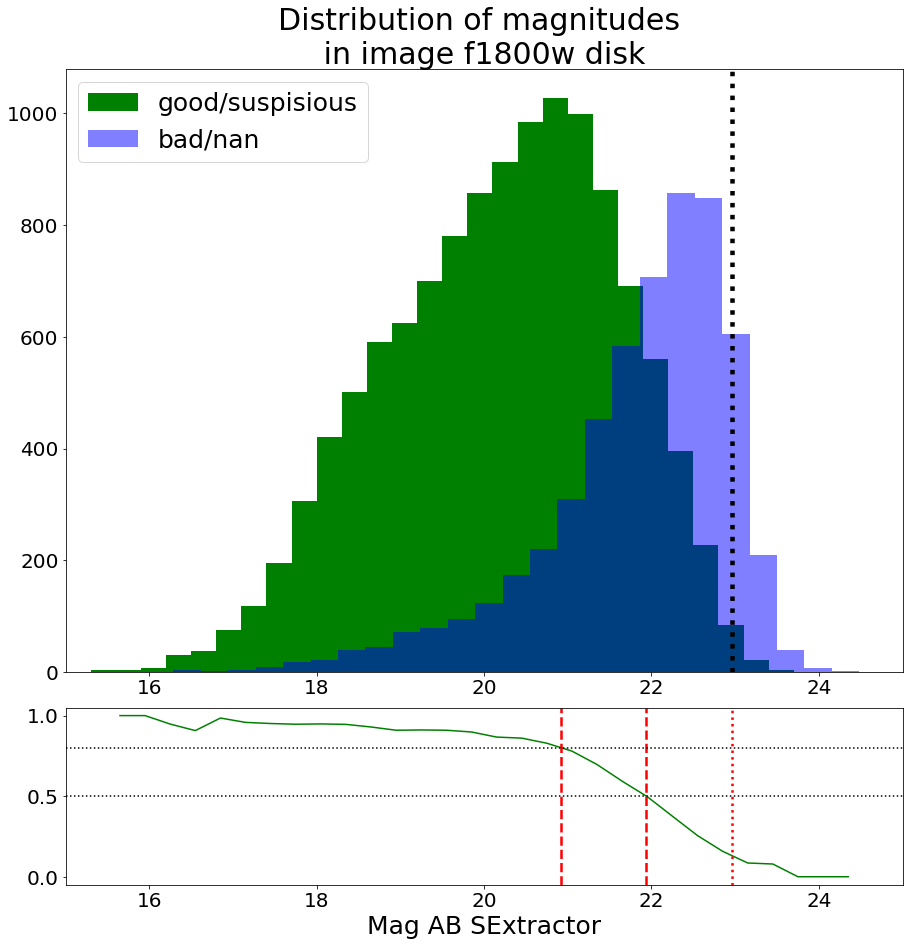

In [21]:
mag_gs = extract_value(ldata,'MAG_BEST',gs)
mag_all = extract_value_all(ldata,'MAG_BEST')
mag_bn = extract_value(ldata,'MAG_BEST',bn)

%matplotlib inline
fig=plt.figure(figsize=(15,15))
axes=fig.subplot_mosaic(
    """
    fff
    fff
    fff
    ppp

    """)

a=np.histogram(mag_gs,range=(15.5,24.5),bins=30)
b=np.histogram(mag_all,bins=a[1])
pg = a[0]/b[0]
pos=[]
for i in range(len(a[0])):
    pos.append((a[1][i]+a[1][i+1])/2)
pg[np.isnan(pg)]=0

axes['f'].hist(mag_gs,range=(15,24),bins=30,color='g',label="good/suspisious",density=False)
axes['f'].hist(mag_bn,alpha=0.5,bins=30,color='b',label='bad/nan',density=False)
axes['f'].axvline(x=22.96,color='k',linestyle=':', linewidth=4.5)
axes['f'].legend(fontsize=25)
axes['f'].tick_params(axis='both', labelsize=20)
axes['p'].set_xlabel("Mag AB SExtractor",fontsize=25)
axes['f'].set_xlim(15,25)
axes['f'].set_title("Distribution of magnitudes \n in image f1800w disk ",fontsize=30)

axes['p'].plot(pos,pg,'g')
axes['p'].axvline(x=22.96,color='r',linestyle=':', linewidth=2.5)
axes['p'].axvline(x=20.92,color='r',linestyle='--', linewidth=2.5)
axes['p'].axvline(x=21.94,color='r',linestyle='--', linewidth=2.5)
axes['p'].axhline(y=0.5,color='k',linestyle=':', linewidth=1.5)
axes['p'].axhline(y=0.8,color='k',linestyle=':', linewidth=1.5)
axes['p'].set_xlim(15,25)
axes['p'].tick_params(axis='both', labelsize=20)



plt.show()

## In vs out 

In [14]:
pixel_scale=fits.open('/local/home/fs269899/stage/jwst_psf/MIRI/psf_1800_oversam.fits')[0].header['PIXELSCL']*5

In [15]:
r_bulge, r_disk, ra_deg, dec_deg, z, m, sfr, mag, q= [], [], [], [], [], [], [], [], []

for c in lcatEGG :
    cat = pycolfits.readfrom(c,lower_case=True)
    b1800=np.where(cat['bands'] == 'jwst-f1800w')[0][0]
    r_bulge.append(cat['bulge_radius']) #arcsec
    r_disk.append(cat['disk_radius']) #arcsec
    ra_deg.append(cat['ra']) #degree
    dec_deg.append(cat['dec']) #degree
    z.append(cat["z"])
    m.append(cat["m"])
    sfr.append(cat['sfr'])
    flux=cat['flux'][:,b1800]
    mag.append(-2.5*np.log10(flux)+23.9)
    q.append(cat['passive'])

In [16]:
ra_pix, dec_pix = [],[]
for i in range(len(limage)) :
    img=fits.open(limage[i])
    header_disk=img[0].header
    w=WCS(header_disk)
    ra,dec= w.wcs_world2pix(ra_deg[i],dec_deg[i],1)
    ra_pix.append(ra)
    dec_pix.append(dec)

In [17]:
mag_detect=[]
for i in mag :
    mag_detect.append(np.where(i<22.96)[0])

In [18]:
cores_out_in_all = []
err_all = []
ok_all = []

for d in range(len(ldata)) :
    data_disk=ldata[d]
    error = 0
    err_cores = []
    ok=[]
    ce = 0
    cores_out_in = []
    
    for gal in trange(len(data_disk['X_IMAGE'])):
        pos, = np.where( ( (data_disk['X_IMAGE'][gal]-data_disk['RE_GALFIT'][gal]) < ra_pix[d][mag_detect[d]] ) & ((data_disk['X_IMAGE'][gal]+data_disk['RE_GALFIT'][gal]) > ra_pix[d][mag_detect[d]]) & 
                      ((data_disk['Y_IMAGE'][gal]-data_disk['RE_GALFIT'][gal]) < dec_pix[d][mag_detect[d]]) & ((data_disk['Y_IMAGE'][gal]+data_disk['RE_GALFIT'][gal]) > dec_pix[d][mag_detect[d]]))
        
        if pos.shape[0]==1 :
            if int(pos[0]) not in cores_out_in :
                pos=np.array([pos[0]])
                ok.append(gal)
            elif int(pos[0]) in cores_out_in : 
                err_cores.append(gal)
                error+=1
                pos=np.array([-1])

        elif pos.shape[0]>1 :
            ce+=1
            i=0
            while pos.shape[0]!=1 :
                pos, = np.where( ( (data_disk['X_IMAGE'][gal]-i) < ra_pix[d][mag_detect[d]] ) & ((data_disk['X_IMAGE'][gal]+i) > ra_pix[d][mag_detect[d]]) & 
                                ((data_disk['Y_IMAGE'][gal]-i) < dec_pix[d][mag_detect[d]]) & ((data_disk['Y_IMAGE'][gal]+i) > dec_pix[d][mag_detect[d]]))
                if pos.shape[0]==1 :
                    if int(pos[0]) not in cores_out_in :
                        pos=np.array([pos[0]])
                        ok.append(gal)
                    elif int(pos[0]) in cores_out_in : 
                        err_cores.append(gal)
                        error+=1
                        pos=np.array([-1])

                if i>1*data_disk['RE_GALFIT'][gal] : #securite contre boucle infini
                    error+=1
                    err_cores.append(gal)
                    pos=np.array([-1])
                i+=0.1   

        elif pos.shape[0]==0 :
            ce+=1
            i=0
            while pos.shape[0]!=1 :
                pos, = np.where( ( (data_disk['X_IMAGE'][gal]-i) < ra_pix[d][mag_detect[d]] ) & ((data_disk['X_IMAGE'][gal]+i) > ra_pix[d][mag_detect[d]]) & 
                                ((data_disk['Y_IMAGE'][gal]-i) < dec_pix[d][mag_detect[d]]) & ((data_disk['Y_IMAGE'][gal]+i) > dec_pix[d][mag_detect[d]]))
                if pos.shape[0]==1 :
                    if int(pos[0]) not in cores_out_in :
                        pos=np.array([pos[0]])
                        ok.append(gal)
                    elif int(pos[0]) in cores_out_in : 
                        err_cores.append(gal)
                        error+=1
                        pos=np.array([-1])

                if i>1*data_disk['RE_GALFIT'][gal]: #securite contre boucle infini
                    error+=1
                    err_cores.append(gal)
                    pos=np.array([-1])
                if (i>400) & (data_disk['FIT_DONE'][gal]==0) :
                    error+=1
                    err_cores.append(gal)
                    pos=np.array([0])
                i+=0.1
    
        cores_out_in.append(int(pos[0]))
        

    cores_out_in_all.append(np.array(cores_out_in))
    ok_all.append(np.array(ok))
    err_all.append(np.array(err_cores))
    print("nbr of error : ",error)

  0%|          | 0/2062 [00:00<?, ?it/s]

nbr of error :  185


  0%|          | 0/2212 [00:00<?, ?it/s]

nbr of error :  188


  0%|          | 0/2202 [00:00<?, ?it/s]

nbr of error :  172


  0%|          | 0/2226 [00:00<?, ?it/s]

nbr of error :  200


  0%|          | 0/2158 [00:00<?, ?it/s]

nbr of error :  182


  0%|          | 0/2127 [00:00<?, ?it/s]

nbr of error :  179


  0%|          | 0/2120 [00:00<?, ?it/s]

nbr of error :  151


In [19]:
non_detct=[]
for i in range(len(mag_detect)) :
    nd=np.ones(mag_detect[i].shape,bool)
    nd[cores_out_in_all[i]]=0
    non_detct.append(nd)

In [20]:
nlgood, nlsusp, nlbad, nlnan = [],[], [], []
for i in range(len(ldata)) :
    data=ldata[i]
    g,s,b,n = flag_results(data[ok_all[i]])
    nlgood.append(g)
    nlsusp.append(s)
    nlbad.append(b)
    nlnan.append(n)

In [21]:
ngs = []
nbn = []

for i in range(len(lgood)):
    ngs.append(np.concatenate((nlgood[i],nlsusp[i])))
    nbn.append(np.concatenate((nlbad[i],nlnan[i])))

### Mag 

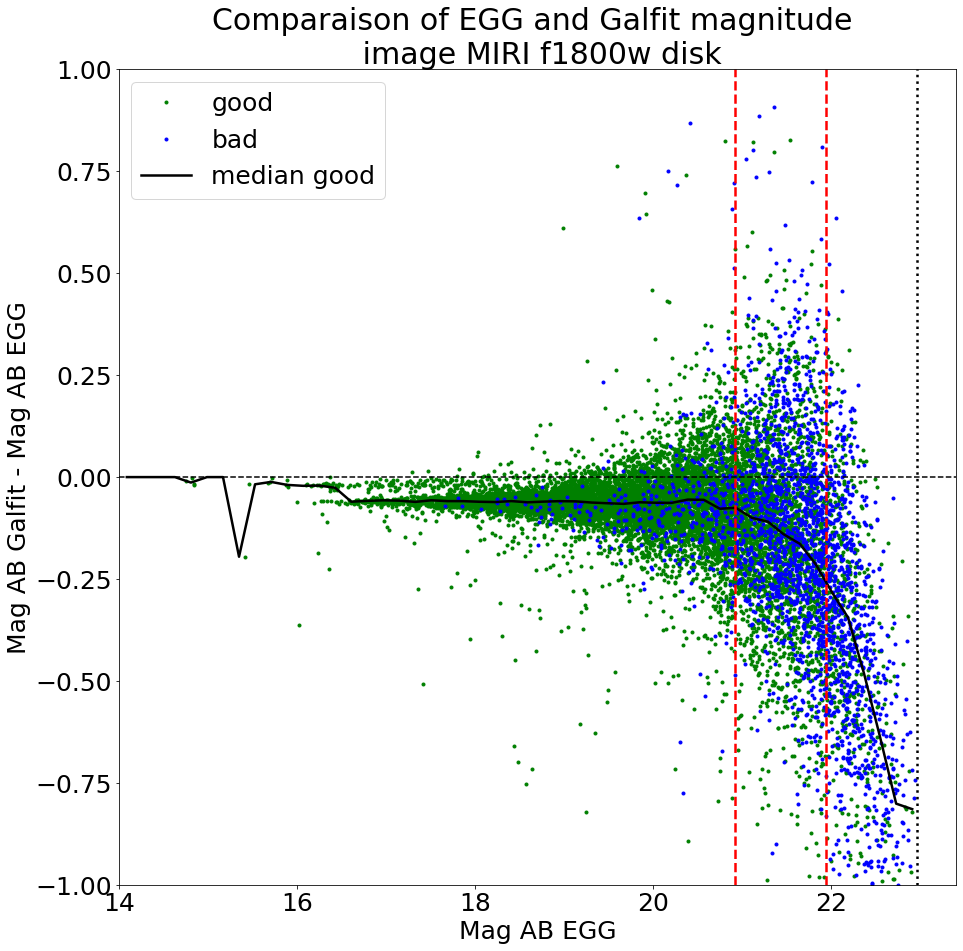

In [22]:
m_gal = np.array([])
m_gal_bn = np.array([])
mag_gs = np.array([])
mag_bn = np.array([])

for i in range(len(r_disk)):
    data_disk=ldata[i]
    m_gal=np.concatenate((m_gal,data_disk['MAG_GALFIT'][ok_all[i]][ngs[i]]))
    mag_gs=np.concatenate((mag_gs,mag[i][mag_detect[i]][cores_out_in_all[i][ok_all[i]]][ngs[i]]))
    
    m_gal_bn=np.concatenate((m_gal_bn,data_disk['MAG_GALFIT'][ok_all[i]][nbn[i]]))
    mag_bn=np.concatenate((mag_bn,mag[i][mag_detect[i]][cores_out_in_all[i][ok_all[i]]][nbn[i]]))

pe_re_g = m_gal-mag_gs
pe_re_b = m_gal_bn-mag_bn

re = []
mag_re=[]

bx=50

for j in range(bx) :
    
    minx= int(mag_gs.min())+( int(mag_gs.max()+1)-int(mag_gs.min())  )/bx*j
    maxx= int(mag_gs.min())+( int(mag_gs.max()+1)-int(mag_gs.min())  )/bx*(j+1)

    m_index,=np.where((mag_gs>minx) & (mag_gs<maxx))
    
    if len((m_gal[m_index]-mag_gs[m_index])) >=1 :
        re.append(np.median((m_gal[m_index]-mag_gs[m_index])))
    else :
        re.append(0)
    mag_re.append((minx+maxx)/2)

%matplotlib inline
plt.figure(figsize=(15,15))
plt.plot(mag_gs,pe_re_g,'g.',label='good')
plt.plot(mag_bn,pe_re_b,'b.',label='bad')
plt.plot(mag_re,re,'k-', label="median good", linewidth=2.5)

plt.axvline(x=22.96,color='k',linestyle=':', linewidth=2.5)
plt.axvline(x=20.92,color='r',linestyle='--', linewidth=2.5)
plt.axvline(x=21.94,color='r',linestyle='--', linewidth=2.5)
plt.axhline(y=0,color='k',linestyle='--', linewidth=1.5)

plt.xlabel('Mag AB EGG',fontsize=25)
plt.ylabel('Mag AB Galfit - Mag AB EGG', fontsize=25)
plt.title("Comparaison of EGG and Galfit magnitude \n image MIRI f1800w disk",fontsize=30)
plt.xlim(14,23.4)
plt.ylim(-1,1)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(loc='upper left',fontsize=25)
plt.show()

### Re

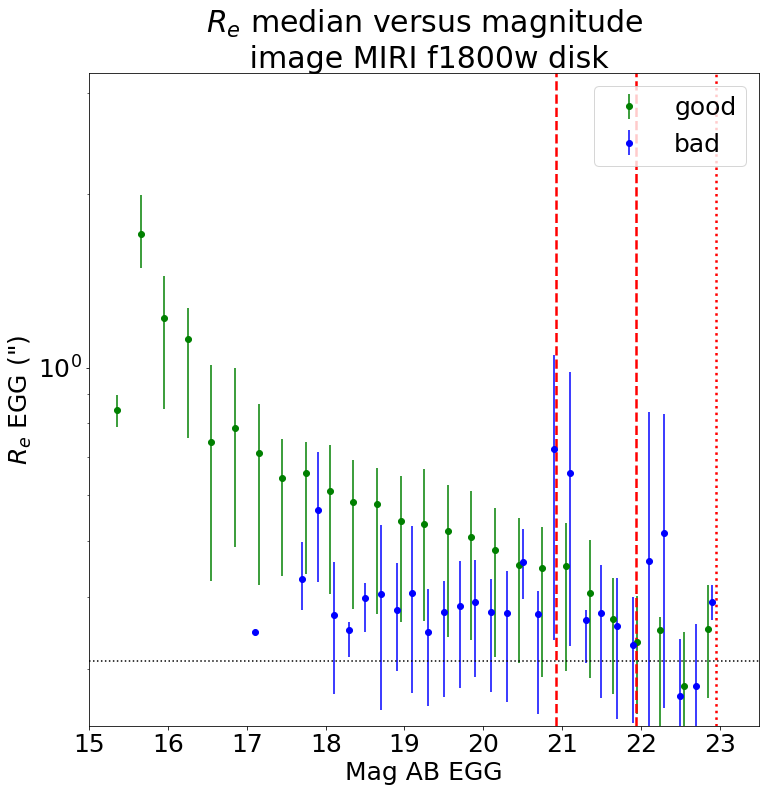

In [23]:
%matplotlib inline

re, re_b = [], []
low_err, high_err, low_err_b, high_err_b = [],[], [],[]
mag_re, mag_re_b =[], []

bx=30

r_d_all = np.array([])
mag_all = np.array([])

r_d_all_b = np.array([])
mag_all_b = np.array([])

for i in range(len(r_disk)):
    r_d_all=np.concatenate((r_d_all,r_disk[i][mag_detect[i]][cores_out_in_all[i]][gs[i]]))
    mag_all=np.concatenate((mag_all,mag[i][mag_detect[i]][cores_out_in_all[i]][gs[i]]))
    
    r_d_all_b=np.concatenate((r_d_all_b,r_disk[i][mag_detect[i]][cores_out_in_all[i]][bn[i]]))
    mag_all_b=np.concatenate((mag_all_b,mag[i][mag_detect[i]][cores_out_in_all[i]][bn[i]]))

for j in range(bx) :
    
    minx= int(mag_all.min())+( int(mag_all.max()+1)-int(mag_all.min())  )/bx*j
    maxx= int(mag_all.min())+( int(mag_all.max()+1)-int(mag_all.min())  )/bx*(j+1)

    m_index,=np.where((mag_all>minx) & (mag_all<maxx))
    
    if len(r_d_all[m_index]) >=1 :
        re.append(np.mean(r_d_all[m_index]))
        low_err.append(abs(np.mean(r_d_all[m_index])-np.quantile(r_d_all[m_index],0.25)))
        high_err.append(abs(np.mean(r_d_all[m_index])-np.quantile(r_d_all[m_index],0.75)))
    else :
        re.append(0)
        low_err.append(0)
        high_err.append(0)
    mag_re.append((minx+maxx)/2)
    
for j in range(bx) :
    
    minx= int(mag_all_b.min())+( int(mag_all_b.max()+1)-int(mag_all_b.min())  )/bx*j
    maxx= int(mag_all_b.min())+( int(mag_all_b.max()+1)-int(mag_all_b.min())  )/bx*(j+1)

    m_index,=np.where((mag_all_b>minx) & (mag_all_b<maxx))
    
    if len(r_d_all_b[m_index]) >=1 :
        re_b.append(np.mean(r_d_all_b[m_index]))
        low_err_b.append(abs(np.mean(r_d_all_b[m_index])-np.quantile(r_d_all_b[m_index],0.25)))
        high_err_b.append(abs(np.mean(r_d_all_b[m_index])-np.quantile(r_d_all_b[m_index],0.75)))
    else :
        re_b.append(0)
        low_err_b.append(0)
        high_err_b.append(0)
    mag_re_b.append((minx+maxx)/2)


errg = [low_err,high_err]
errs = [low_err_b,high_err_b]
fwhm=18/6e6/np.pi*180*3600
plt.figure(figsize=(12,12))
plt.errorbar(mag_re,re,yerr=errg,fmt="go",label="good")
plt.errorbar(mag_re_b,re_b,yerr=errs,fmt="bo",label="bad")
plt.axvline(x=22.96,color='r',linestyle=':', linewidth=2.5)
plt.axvline(x=20.92,color='r',linestyle='--', linewidth=2.5)
plt.axvline(x=21.94,color='r',linestyle='--', linewidth=2.5)
plt.axhline(y=fwhm/2,color='k',linestyle=':')
#plt.axhline(y=pixel_scale)
plt.xlabel(r'Mag AB EGG',fontsize=25)
plt.ylabel(r'$R_e$ EGG (")', fontsize=25)
plt.title(r'$R_e$ median versus magnitude' + '\n image MIRI f1800w disk', fontsize=30)
plt.xlim(15,23.5)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(loc='upper right',fontsize=25)
#plt.ylim(5e-2,7e-1)
#plt.ylim(0,0.5)
plt.semilogy()
plt.show()

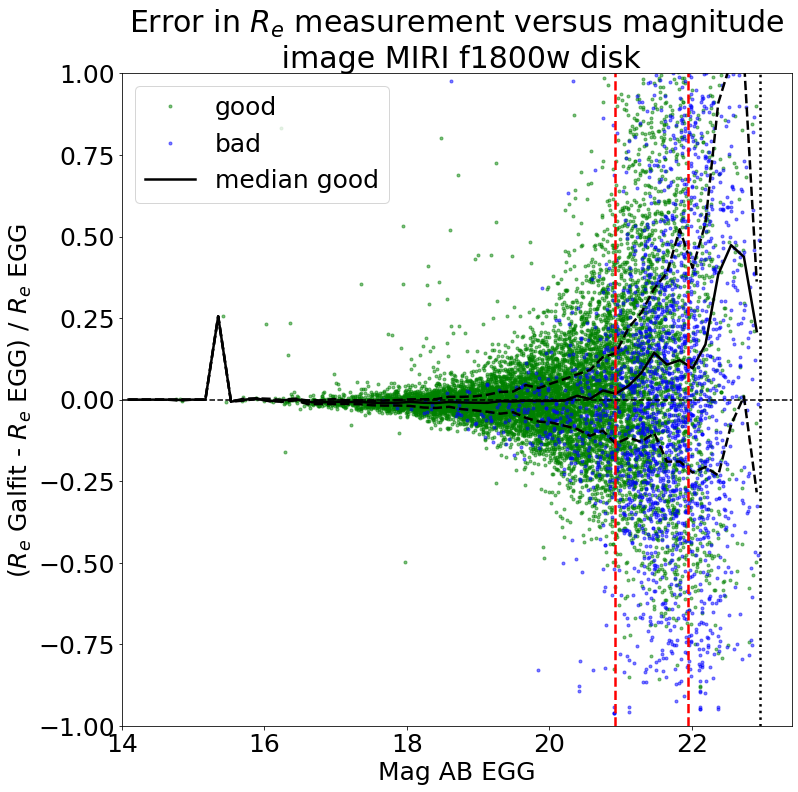

In [24]:
r_d_all = np.array([])
re_gal = np.array([])
re_gal_bn = np.array([])
r_d_all_bn = np.array([])
mag_gs = np.array([])
mag_bn = np.array([])

for i in range(len(r_disk)):
    data_disk=ldata[i]
    r_d_all=np.concatenate((r_d_all,r_disk[i][mag_detect[i]][cores_out_in_all[i][ok_all[i]]][ngs[i]]))
    re_gal=np.concatenate((re_gal,data_disk['RE_GALFIT'][ok_all[i]][ngs[i]]*pixel_scale))
    mag_gs=np.concatenate((mag_gs,mag[i][mag_detect[i]][cores_out_in_all[i][ok_all[i]]][ngs[i]]))
    
    r_d_all_bn=np.concatenate((r_d_all_bn,r_disk[i][mag_detect[i]][cores_out_in_all[i][ok_all[i]]][nbn[i]]))
    re_gal_bn=np.concatenate((re_gal_bn,data_disk['RE_GALFIT'][ok_all[i]][nbn[i]]*pixel_scale))
    mag_bn=np.concatenate((mag_bn,mag[i][mag_detect[i]][cores_out_in_all[i][ok_all[i]]][nbn[i]]))

pe_re_g = (re_gal-r_d_all)/r_d_all
pe_re_b = (re_gal_bn-r_d_all_bn)/r_d_all_bn

re = []
mag_re=[]
low_err, high_err = [],[]

bx=50

for j in range(bx) :
    
    minx= int(mag_gs.min())+( int(mag_gs.max()+1)-int(mag_gs.min())  )/bx*j
    maxx= int(mag_gs.min())+( int(mag_gs.max()+1)-int(mag_gs.min())  )/bx*(j+1)

    m_index,=np.where((mag_gs>minx) & (mag_gs<maxx))
    
    if len((re_gal[m_index]-r_d_all[m_index])/r_d_all[m_index]) >=1 :
        re.append(np.median(((re_gal[m_index]-r_d_all[m_index])/r_d_all[m_index])))
        low_err.append(abs(np.median(((re_gal[m_index]-r_d_all[m_index])/r_d_all[m_index]))-np.quantile(((re_gal[m_index]-r_d_all[m_index])/r_d_all[m_index]),0.25)))
        high_err.append(abs(np.median(((re_gal[m_index]-r_d_all[m_index])/r_d_all[m_index]))-np.quantile(((re_gal[m_index]-r_d_all[m_index])/r_d_all[m_index]),0.7)))
    else :
        re.append(0)
        low_err.append(0)
        high_err.append(0)
    mag_re.append((minx+maxx)/2)

%matplotlib inline
plt.figure(figsize=(12,12))
plt.plot(mag_gs,pe_re_g,'g.',alpha=0.5,label='good')
plt.plot(mag_bn,pe_re_b,'b.',alpha=0.5,label='bad')
plt.plot(mag_re,re,'k-', label="median good", linewidth=2.5)
plt.plot(mag_re,np.array(re)-np.array(low_err),'k--', linewidth=2.5)
plt.plot(mag_re,np.array(re)+np.array(high_err),'k--',linewidth=2.5)

plt.axvline(x=22.96,color='k',linestyle=':', linewidth=2.5)
plt.axvline(x=20.92,color='r',linestyle='--', linewidth=2.5)
plt.axvline(x=21.94,color='r',linestyle='--', linewidth=2.5)
plt.axhline(y=0,color='k',linestyle='--', linewidth=1.5)

plt.xlabel(r'Mag AB EGG',fontsize=25)
plt.ylabel(r'($R_e$ Galfit - $R_e$ EGG) / $R_e$ EGG', fontsize=25)
plt.title( r'Error in $R_e$ measurement versus magnitude' + '\n image MIRI f1800w disk', fontsize=30)
plt.xlim(14,23.4)
plt.ylim(-1,1)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(loc='upper left',fontsize=25)
plt.show()

### SFR 

In [25]:
nlgood, nlsusp, nlbad, nlnan = [],[], [], []
for i in range(len(ldata)) :
    data=ldata[i]
    g,s,b,n = flag_results_m80(data[ok_all[i]],21.94)
    nlgood.append(g)
    nlsusp.append(s)
    nlbad.append(b)
    nlnan.append(n)

In [26]:
ngs = []
nbn = []

for i in range(len(lgood)):
    ngs.append(np.concatenate((nlgood[i],nlsusp[i])))
    nbn.append(np.concatenate((nlbad[i],nlnan[i])))

In [27]:
lgood, lsusp, lbad, lnan = [],[], [], []
for data in ldata :
    g,s,b,n = flag_results_m80(data,21.94)
    lgood.append(g)
    lsusp.append(s)
    lbad.append(b)
    lnan.append(n)

In [28]:
gs = []
bn = []

for i in range(len(lgood)):
    gs.append(np.concatenate((lgood[i],lsusp[i])))
    bn.append(np.concatenate((lbad[i],lnan[i])))

In [29]:
bx=40 #bin x
by=40 #bin y
zb=[0,0.5,1,1.5,2.5,3.5,15]

imgz=[]
t, tQ, tSF = [], [], []
g, gQ, gSF = [], [], []


for k in trange(len(zb)-1):

    img=[]
    
    tot=np.zeros((bx,by))
    totQ=np.zeros((bx,by))
    totSF=np.zeros((bx,by))
    ntg=np.zeros((bx,by))
    ntgQ=np.zeros((bx,by))
    ntgSF=np.zeros((bx,by))

    for i in range(by) : 
        l=[]
        
        
        
        for j in range(bx) :
            
            
            # a fixer pour toutes les img
            zl = np.where((z[1][mag_detect[1]]>zb[k])&(z[1][mag_detect[1]]<zb[k+1]))[0]
            minx= int(m[1][mag_detect[1]][zl].min())+( int(m[1][mag_detect[1]][zl].max()+1)-int(m[1][mag_detect[1]][zl].min())  )/bx*j
            maxx= int(m[1][mag_detect[1]][zl].min())+( int(m[1][mag_detect[1]][zl].max()+1)-int(m[1][mag_detect[1]][zl].min())  )/bx*(j+1)
            miny= int(np.log10(sfr[1][mag_detect[1]][zl]).min()-1)+( int(np.log10(sfr[1][mag_detect[1]][zl]).max()+1)-int(np.log10(sfr[1][mag_detect[1]][zl]).min()-1 ) )/by*i
            maxy= int(np.log10(sfr[1][mag_detect[1]][zl]).min()-1)+( int(np.log10(sfr[1][mag_detect[1]][zl]).max()+1)-int(np.log10(sfr[1][mag_detect[1]][zl]).min()-1) )/by*(i+1)
            
            
            ntot = 0
            ntQ =  0
            ntSF = 0
            ngsT = 0
            ngsQT = 0
            ngsSFT = 0
            nbnT = 0
            nnfT = 0
            for d in range(len(ldata)) :
                #tot
                zl = np.where((z[d][mag_detect[d]]>zb[k])&(z[d][mag_detect[d]]<zb[k+1]))[0]
                ntot += np.where( (m[d][mag_detect[d]][zl]>minx) & (m[d][mag_detect[d]][zl]<maxx) & 
                                 (np.log10(sfr[d][mag_detect[d]][zl]) > miny) & (np.log10(sfr[d][mag_detect[d]][zl]) < maxy) )[0].shape[0]
                
                Q=np.where(q[d][mag_detect[d]][zl]==1)[0]
                ntQ += np.where( (m[d][mag_detect[d]][zl][Q]>minx) & (m[d][mag_detect[d]][zl][Q]<maxx) & 
                                 (np.log10(sfr[d][mag_detect[d]][zl][Q]) > miny) & (np.log10(sfr[d][mag_detect[d]][zl][Q]) < maxy) )[0].shape[0]
                
                Q=np.where(q[d][mag_detect[d]][zl]==0)[0]
                ntSF += np.where( (m[d][mag_detect[d]][zl][Q]>minx) & (m[d][mag_detect[d]][zl][Q]<maxx) & 
                                 (np.log10(sfr[d][mag_detect[d]][zl][Q]) > miny) & (np.log10(sfr[d][mag_detect[d]][zl][Q]) < maxy) )[0].shape[0]
                
                #good
                zl = np.where((z[d][mag_detect[d]][cores_out_in_all[d]][gs[d]]>zb[k])&(z[d][mag_detect[d]][cores_out_in_all[d]][gs[d]]<zb[k+1]))[0]
                ngsT += np.where( (m[d][mag_detect[d]][cores_out_in_all[d]][gs[d]][zl]>minx) & (m[d][mag_detect[d]][cores_out_in_all[d]][gs[d]][zl]<maxx) & 
                               (np.log10(sfr[d][mag_detect[d]][cores_out_in_all[d]][gs[d]][zl]) > miny) & (np.log10(sfr[d][mag_detect[d]][cores_out_in_all[d]][gs[d]][zl]) < maxy) )[0].shape[0]
                
                Q=np.where(q[d][mag_detect[d]][cores_out_in_all[d]][gs[d]][zl]==1)[0]
                ngsQT += np.where( (m[d][mag_detect[d]][cores_out_in_all[d]][gs[d]][zl][Q]>minx) & (m[d][mag_detect[d]][cores_out_in_all[d]][gs[d]][zl][Q]<maxx) & 
                               (np.log10(sfr[d][mag_detect[d]][cores_out_in_all[d]][gs[d]][zl][Q]) > miny) & (np.log10(sfr[d][mag_detect[d]][cores_out_in_all[d]][gs[d]][zl][Q]) < maxy) )[0].shape[0]
                
                Q=np.where(q[d][mag_detect[d]][cores_out_in_all[d]][gs[d]][zl]==0)[0]
                ngsSFT += np.where( (m[d][mag_detect[d]][cores_out_in_all[d]][gs[d]][zl][Q]>minx) & (m[d][mag_detect[d]][cores_out_in_all[d]][gs[d]][zl][Q]<maxx) & 
                               (np.log10(sfr[d][mag_detect[d]][cores_out_in_all[d]][gs[d]][zl][Q]) > miny) & (np.log10(sfr[d][mag_detect[d]][cores_out_in_all[d]][gs[d]][zl][Q]) < maxy) )[0].shape[0]
                
                #bad
                zl = np.where((z[d][mag_detect[d]][cores_out_in_all[d]][bn[d]]>zb[k])&(z[d][mag_detect[d]][cores_out_in_all[d]][bn[d]]<zb[k+1]))[0]
                nbnT += np.where( (m[d][mag_detect[d]][cores_out_in_all[d]][bn[d]][zl]>minx) & (m[d][mag_detect[d]][cores_out_in_all[d]][bn[d]][zl]<maxx) & 
                               (np.log10(sfr[d][mag_detect[d]][cores_out_in_all[d]][bn[d]][zl]) > miny) & (np.log10(sfr[d][mag_detect[d]][cores_out_in_all[d]][bn[d]][zl]) < maxy) )[0].shape[0]
                
                #non detect
                zl = np.where((z[d][mag_detect[d]][non_detct[d]]>zb[k])&(z[d][mag_detect[d]][non_detct[d]]<zb[k+1]))[0]
                nnfT += np.where( (m[d][mag_detect[d]][non_detct[d]][zl]>minx) & (m[d][mag_detect[d]][non_detct[d]][zl]<maxx) & 
                                (np.log10(sfr[d][mag_detect[d]][non_detct[d]][zl]) > miny) & (np.log10(sfr[d][mag_detect[d]][non_detct[d]][zl]) < maxy) )[0].shape[0]

                
            
            tot[i][j]=ntot
            totQ[i][j]=ntQ
            totSF[i][j]=ntSF

            if ntot ==0 :
                l.append([1.,1.,1.])
                
            else:
                ngs = ngsT/ntot
                ntg[i][j]=ngsT
                ntgQ[i][j]=ngsQT
                ntgSF[i][j]=ngsSFT
                nbn = nbnT/ntot
                nnf = nnfT/ntot
                
                l.append([nnf,ngs,nbn])
                
                

        img.append(l)
        
    t.append(tot)
    tQ.append(totQ)
    tSF.append(totSF)
    g.append(ntg)
    gQ.append(ntgQ)
    gSF.append(ntgSF)
    imgz.append(img)

  0%|          | 0/6 [00:00<?, ?it/s]

/tmp/ipykernel_12507/3408630467.py:14: RuntimeWarning: invalid value encountered in true_divide
  sfrg=np.sum(g[i],axis=0)/np.sum(t[i],axis=0)
/tmp/ipykernel_12507/3408630467.py:17: RuntimeWarning: invalid value encountered in true_divide
  sfrgQ=np.sum(gQ[i],axis=0)/np.sum(tQ[i],axis=0)
/tmp/ipykernel_12507/3408630467.py:20: RuntimeWarning: invalid value encountered in true_divide
  sfrgSF=np.sum(gSF[i],axis=0)/np.sum(tSF[i],axis=0)
/tmp/ipykernel_12507/3408630467.py:25: RuntimeWarning: invalid value encountered in true_divide
  mg=np.sum(gSF[i],axis=1)/np.sum(t[i],axis=1)


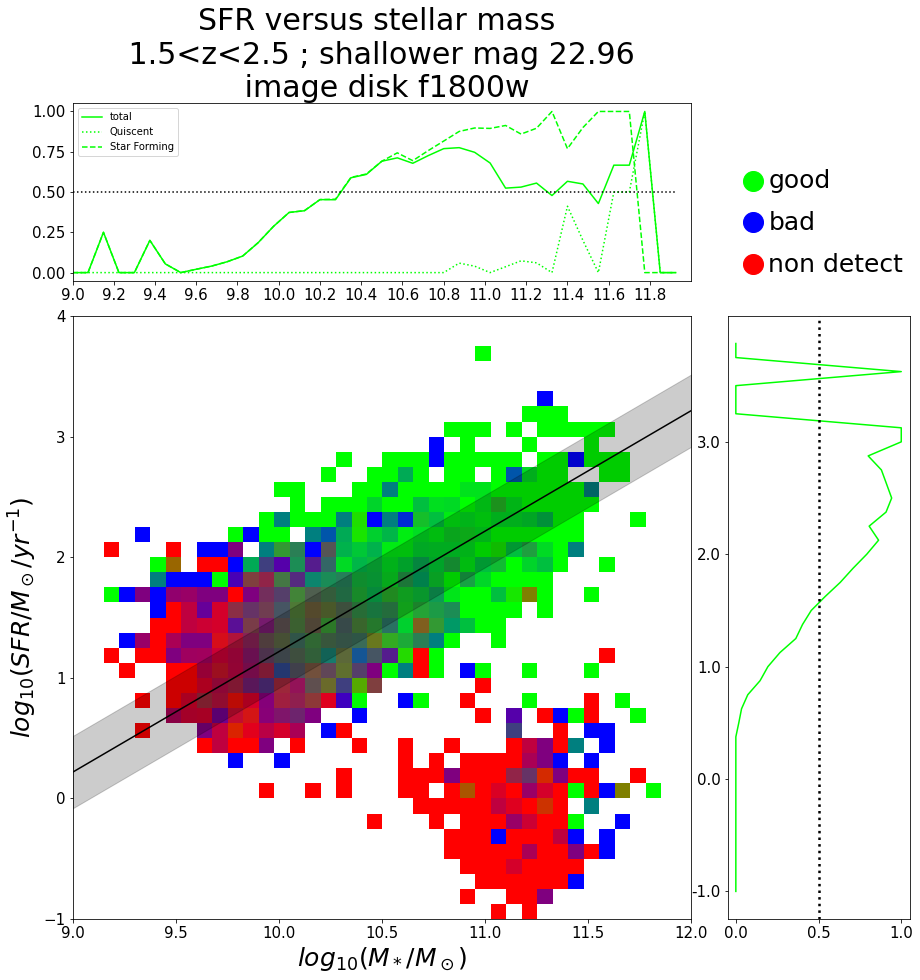

In [30]:
i=3

zl = np.where((z[1][mag_detect[1]]>zb[i])&(z[1][mag_detect[1]]<zb[i+1]))[0]
#ntx = int(m[1][mag_detect[1]][zl].max()+1)-int(m[1][mag_detect[1]][zl].min())
ntx = 2*int(m[1][mag_detect[1]][zl].max()+1)-int(m[1][mag_detect[1]][zl].min())
nx=np.arange(0,np.array(img).shape[0],np.array(img).shape[0]/ntx)
lx=np.around(np.arange(int(m[1][mag_detect[1]][zl].min()),int(m[1][mag_detect[1]][zl].max()+1),( int(m[1][mag_detect[1]][zl].max()+1)-int(m[1][mag_detect[1]][zl].min())  )/ntx),decimals=2)

nty = int(np.log10(sfr[1][mag_detect[1]][zl]).max()+1)-int(np.log10(sfr[1][mag_detect[1]][zl]).min()-1)
ny=np.arange(0,np.array(img).shape[1],np.array(img).shape[0]/nty)
ly=np.around(np.arange(int(np.log10(sfr[1][mag_detect[1]][zl]).min()-1),int(np.log10(sfr[1][mag_detect[1]][zl]).max()+1),( int(np.log10(sfr[1][mag_detect[1]][zl]).max()+1)-int(np.log10(sfr[1][mag_detect[1]][zl]).min()-1)  )/nty),decimals=2)


sfrg=np.sum(g[i],axis=0)/np.sum(t[i],axis=0)
sfrg[np.isnan(sfrg)]=0

sfrgQ=np.sum(gQ[i],axis=0)/np.sum(tQ[i],axis=0)
sfrgQ[np.isnan(sfrgQ)]=0

sfrgSF=np.sum(gSF[i],axis=0)/np.sum(tSF[i],axis=0)
sfrgSF[np.isnan(sfrgSF)]=0

x=np.arange(sfrg.shape[0])

mg=np.sum(gSF[i],axis=1)/np.sum(t[i],axis=1)
mg[np.isnan(mg)]=0
y=np.arange(mg.shape[0])


xMS = np.arange(int(m[1][mag_detect[1]][zl].min()),int(m[1][mag_detect[1]][zl].max()+1)+0.1,0.1)
logzMS = np.log10(1+(zb[i]+zb[i+1])/2)
yMS=xMS-9.5+1.5*logzMS-0.3*(max(0,xMS.any()-9.36-2.5*logzMS))**2
                    


fig=plt.figure(figsize=(15,15))
#fig.subplots_adjust(left=0.2, right=0.8, bottom=0.1, top=0.9)
axes=fig.subplot_mosaic(
    """
    aaal
    bbbc
    bbbc
    bbbc
    """)
axes['a'].set_title("SFR versus stellar mass \n {}<z<{} ; shallower mag 22.96 \n image disk f1800w".format(zb[i],zb[i+1]),fontsize=30)

axes['a'].plot(x,sfrg,color=(0,1,0),label='total')
axes['a'].plot(x,sfrgQ,':',color=(0,1,0),label='Quiscent')
axes['a'].plot(x,sfrgSF,'--',color=(0,1,0),label='Star Forming')
axes['a'].plot(x,np.ones(x.shape[0])*0.5,'k:')
axes['a'].set_xticks(nx,lx,fontsize=15)
axes['a'].set_xlim(0,sfrg.shape[0])
axes['a'].tick_params(axis='y', labelsize= 15)
#axes['a'].set_ylim(0,1.1)
axes['a'].legend()

axes['c'].plot(mg,y,color=(0,1,0))
axes['c'].set_yticks(ny,ly,fontsize=15)
axes['c'].tick_params(axis='x', labelsize= 15)
axes['c'].axvline(x=0.5,color='k',linestyle=':', linewidth=2.5)
#axes['c'].set_ylim(0,mg.shape[0])



axes['b'].imshow(imgz[i],origin='lower',
                 extent=[int(m[1][mag_detect[1]][zl].min()),int(m[1][mag_detect[1]][zl].max()+1),int(np.log10(sfr[1][mag_detect[1]][zl]).min()-1),int(np.log10(sfr[1][mag_detect[1]][zl]).max()+1)],
                 aspect='auto')
axes['b'].set_xlabel(r'$log_{10}(M_*/M_\odot)$',fontsize=25)
axes['b'].set_ylabel(r'$log_{10}(SFR/M_\odot/yr^{-1})$', fontsize=25)
axes['b'].tick_params(axis='x', labelsize= 15)
axes['b'].tick_params(axis='y', labelsize= 15)
axes['b'].plot(xMS,yMS,'k')
axes['b'].fill_between(xMS,yMS-0.3,yMS+0.3,color='k',alpha=0.2)

axes['l'].plot(0,2.15,'o',color=(0,1,0),ms=20,label='good')
axes['l'].plot(0,1.2,'bo',ms=20,label='bad')
axes['l'].plot(0,0.2,'ro',ms=20,label='non detect')
axes['l'].set_xlim(-0.008,0.05)
axes['l'].set_ylim(-0.2,4)
axes['l'].text(0.005,2,"good",fontsize=25)
axes['l'].text(0.005,1,"bad",fontsize=25)
axes['l'].text(0.005,0,"non detect",fontsize=25)
axes['l'].axis('off')

plt.show()

# Disque RE/2

## catalogue 

In [7]:
lcombcat=["combcat1800_1_disk_L2_nf.fits",
          "combcat1800_2_disk_L2_nf.fits",
          "combcat1800_3_disk_L2_nf.fits",
          "combcat1800_4_disk_L2_nf.fits",
          "combcat1800_5_disk_L2_nf.fits",
          "combcat1800_6_disk_L2_nf.fits",
          "combcat1800_7_disk_L2_nf.fits",
          "combcat1800_8_disk_L2_nf.fits"]

In [8]:
ldata=[]
for i in range(len(lcombcat)) : 
    disk = fits.open(lcombcat[i])
    data_disk=disk[1].data
    ldata.append(data_disk)

In [9]:
lgood, lsusp, lbad, lnan = [],[], [], []
for data in ldata :
    g,s,b,n = flag_results(data)
    lgood.append(g)
    lsusp.append(s)
    lbad.append(b)
    lnan.append(n)

gs = []
bn = []

for i in range(len(lgood)):
    gs.append(np.concatenate((lgood[i],lsusp[i])))
    bn.append(np.concatenate((lbad[i],lnan[i])))

In [9]:
lgood, lsusp, lbad, lnan = [],[], [], []
for data in ldata :
    g,s,b,n = flag_results_m80(data,21.6)
    lgood.append(g)
    lsusp.append(s)
    lbad.append(b)
    lnan.append(n)

gs = []
bn = []

for i in range(len(lgood)):
    gs.append(np.concatenate((lgood[i],lsusp[i])))
    bn.append(np.concatenate((lbad[i],lnan[i])))

In [10]:
limage=["/local/home/fs269899/stage/egg_jwst/PRIMER/MIRI/f1800w/img1/egg-20220422-jwst-f1800w-sci_disk_adu.fits",
        "/local/home/fs269899/stage/egg_jwst/PRIMER/MIRI/f1800w/img2/egg-20220512-jwst-f1800w-sci_disk_adu.fits",
        "/local/home/fs269899/stage/egg_jwst/PRIMER/MIRI/f1800w/img3/egg-20220512-jwst-f1800w-sci_disk_adu.fits",
        "/local/home/fs269899/stage/egg_jwst/PRIMER/MIRI/f1800w/img4/egg-20220513-jwst-f1800w-sci_disk_adu.fits",
        "/local/home/fs269899/stage/egg_jwst/PRIMER/MIRI/f1800w/img5/egg-20220513-jwst-f1800w-sci_disk_adu.fits",
        "/local/home/fs269899/stage/egg_jwst/PRIMER/MIRI/f1800w/img6/egg-20220513-jwst-f1800w-sci_disk_adu.fits",
        "/local/home/fs269899/stage/egg_jwst/PRIMER/MIRI/f1800w/img7/egg-20220513-jwst-f1800w-sci_disk_adu.fits",
        "/local/home/fs269899/stage/egg_jwst/PRIMER/MIRI/f1800w/img8/egg-20220513-jwst-f1800w-sci_disk_adu.fits"]

In [11]:
lcatEGG=["/local/home/fs269899/stage/egg_jwst/PRIMER/MIRI/f1800w/img1/egg-20220422.fits",
         "/local/home/fs269899/stage/egg_jwst/PRIMER/MIRI/f1800w/img2/egg-20220512.fits",
         "/local/home/fs269899/stage/egg_jwst/PRIMER/MIRI/f1800w/img3/egg-20220512.fits",
         "/local/home/fs269899/stage/egg_jwst/PRIMER/MIRI/f1800w/img4/egg-20220513.fits",
         "/local/home/fs269899/stage/egg_jwst/PRIMER/MIRI/f1800w/img5/egg-20220513.fits",
         "/local/home/fs269899/stage/egg_jwst/PRIMER/MIRI/f1800w/img6/egg-20220513.fits",
         "/local/home/fs269899/stage/egg_jwst/PRIMER/MIRI/f1800w/img7/egg-20220513.fits",
         "/local/home/fs269899/stage/egg_jwst/PRIMER/MIRI/f1800w/img8/egg-20220513.fits"]

In [12]:
tot=0
ng = 0
ns = 0
for data in ldata :
    print(data['FIT_DONE'].shape[0])
    tot=tot+data['FIT_DONE'].shape[0]
    
for i in range(len(lgood)):
    ng = ng + lgood[i].shape[0]
    ns = ns + lsusp[i].shape[0]
print("total: ",tot,", avec",ng,"good et",ns,"suspicieux")

2403
2496
2489
2517
2426
2417
2454
2452
total:  19654 , avec 8325 good et 3175 suspicieux


In [13]:
tot=0
ng = 0
ns = 0
for data in ldata :
    #print(data['FIT_DONE'].shape[0])
    tot=tot+data['FIT_DONE'].shape[0]
    
for i in range(len(lgood)):
    ng = ng + gs[i].shape[0]
    ns = ns + bn[i].shape[0]
print("gs: ",ng/tot,", bad",ns/tot)

gs:  0.5851226213493437 , bad 0.4148773786506564


## Mag 

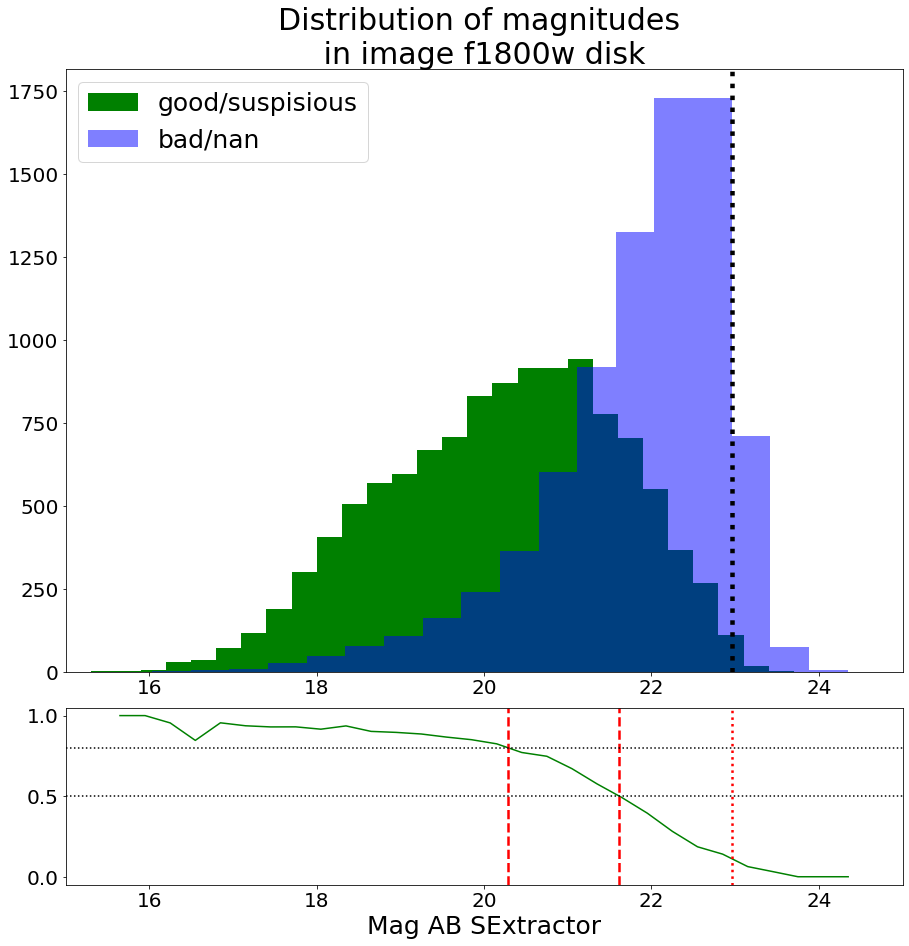

In [14]:
mag_gs = extract_value(ldata,'MAG_BEST',gs)
mag_all = extract_value_all(ldata,'MAG_BEST')
mag_bn = extract_value(ldata,'MAG_BEST',bn)

%matplotlib inline
fig=plt.figure(figsize=(15,15))
axes=fig.subplot_mosaic(
    """
    fff
    fff
    fff
    ppp

    """)

a=np.histogram(mag_gs,range=(15.5,24.5),bins=30)
b=np.histogram(mag_all,bins=a[1])
pg = a[0]/b[0]
pos=[]
for i in range(len(a[0])):
    pos.append((a[1][i]+a[1][i+1])/2)
pg[np.isnan(pg)]=0

axes['f'].hist(mag_gs,range=(15,24),bins=30,color='g',label="good/suspisious",density=False)
axes['f'].hist(mag_bn,alpha=0.5,bins=30,color='b',label='bad/nan',density=False)
axes['f'].axvline(x=22.96,color='k',linestyle=':', linewidth=4.5)
axes['f'].legend(fontsize=25)
axes['f'].tick_params(axis='both', labelsize=20)
axes['p'].set_xlabel("Mag AB SExtractor",fontsize=25)
axes['f'].set_xlim(15,25)
axes['f'].set_title("Distribution of magnitudes \n in image f1800w disk ",fontsize=30)

axes['p'].plot(pos,pg,'g')
axes['p'].axvline(x=22.96,color='r',linestyle=':', linewidth=2.5)
axes['p'].axvline(x=21.61,color='r',linestyle='--', linewidth=2.5)
axes['p'].axvline(x=20.28,color='r',linestyle='--', linewidth=2.5)
axes['p'].axhline(y=0.5,color='k',linestyle=':', linewidth=1.5)
axes['p'].axhline(y=0.8,color='k',linestyle=':', linewidth=1.5)
axes['p'].set_xlim(15,25)
axes['p'].tick_params(axis='both', labelsize=20)



plt.show()

## In vs out 

In [14]:
pixel_scale=fits.open('/local/home/fs269899/stage/jwst_psf/MIRI/psf_1800_oversam.fits')[0].header['PIXELSCL']*5

In [15]:
r_bulge, r_disk, ra_deg, dec_deg, z, m, sfr, mag, q= [], [], [], [], [], [], [], [], []

for c in lcatEGG :
    cat = pycolfits.readfrom(c,lower_case=True)
    b1800=np.where(cat['bands'] == 'jwst-f1800w')[0][0]
    r_bulge.append(cat['bulge_radius']) #arcsec
    r_disk.append(cat['disk_radius']) #arcsec
    ra_deg.append(cat['ra']) #degree
    dec_deg.append(cat['dec']) #degree
    z.append(cat["z"])
    m.append(cat["m"])
    sfr.append(cat['sfr'])
    flux=cat['flux'][:,b1800]
    mag.append(-2.5*np.log10(flux)+23.9)
    q.append(cat['passive'])

In [16]:
ra_pix, dec_pix = [],[]
for i in range(len(limage)) :
    img=fits.open(limage[i])
    header_disk=img[0].header
    w=WCS(header_disk)
    ra,dec= w.wcs_world2pix(ra_deg[i],dec_deg[i],1)
    ra_pix.append(ra)
    dec_pix.append(dec)

In [17]:
mag_detect=[]
for i in mag :
    mag_detect.append(np.where(i<22.96)[0])

In [18]:
cores_out_in_all = []
err_all = []
ok_all = []

for d in range(len(ldata)) :
    data_disk=ldata[d]
    error = 0
    err_cores = []
    ok=[]
    ce = 0
    cores_out_in = []
    
    for gal in trange(len(data_disk['X_IMAGE'])):
        pos, = np.where( ( (data_disk['X_IMAGE'][gal]-data_disk['RE_GALFIT'][gal]) < ra_pix[d][mag_detect[d]] ) & ((data_disk['X_IMAGE'][gal]+data_disk['RE_GALFIT'][gal]) > ra_pix[d][mag_detect[d]]) & 
                      ((data_disk['Y_IMAGE'][gal]-data_disk['RE_GALFIT'][gal]) < dec_pix[d][mag_detect[d]]) & ((data_disk['Y_IMAGE'][gal]+data_disk['RE_GALFIT'][gal]) > dec_pix[d][mag_detect[d]]))
        
        if pos.shape[0]==1 :
            if int(pos[0]) not in cores_out_in :
                pos=np.array([pos[0]])
                ok.append(gal)
            elif int(pos[0]) in cores_out_in : 
                err_cores.append(gal)
                error+=1
                pos=np.array([-1])

        elif pos.shape[0]>1 :
            ce+=1
            i=0
            while pos.shape[0]!=1 :
                pos, = np.where( ( (data_disk['X_IMAGE'][gal]-i) < ra_pix[d][mag_detect[d]] ) & ((data_disk['X_IMAGE'][gal]+i) > ra_pix[d][mag_detect[d]]) & 
                                ((data_disk['Y_IMAGE'][gal]-i) < dec_pix[d][mag_detect[d]]) & ((data_disk['Y_IMAGE'][gal]+i) > dec_pix[d][mag_detect[d]]))
                if pos.shape[0]==1 :
                    if int(pos[0]) not in cores_out_in :
                        pos=np.array([pos[0]])
                        ok.append(gal)
                    elif int(pos[0]) in cores_out_in : 
                        err_cores.append(gal)
                        error+=1
                        pos=np.array([-1])

                if i>1*data_disk['RE_GALFIT'][gal] : #securite contre boucle infini
                    error+=1
                    err_cores.append(gal)
                    pos=np.array([-1])
                i+=0.1   

        elif pos.shape[0]==0 :
            ce+=1
            i=0
            while pos.shape[0]!=1 :
                pos, = np.where( ( (data_disk['X_IMAGE'][gal]-i) < ra_pix[d][mag_detect[d]] ) & ((data_disk['X_IMAGE'][gal]+i) > ra_pix[d][mag_detect[d]]) & 
                                ((data_disk['Y_IMAGE'][gal]-i) < dec_pix[d][mag_detect[d]]) & ((data_disk['Y_IMAGE'][gal]+i) > dec_pix[d][mag_detect[d]]))
                if pos.shape[0]==1 :
                    if int(pos[0]) not in cores_out_in :
                        pos=np.array([pos[0]])
                        ok.append(gal)
                    elif int(pos[0]) in cores_out_in : 
                        err_cores.append(gal)
                        error+=1
                        pos=np.array([-1])

                if i>1*data_disk['RE_GALFIT'][gal]: #securite contre boucle infini
                    error+=1
                    err_cores.append(gal)
                    pos=np.array([-1])
                if (i>400) & (data_disk['FIT_DONE'][gal]==0) :
                    error+=1
                    err_cores.append(gal)
                    pos=np.array([0])
                i+=0.1
    
        cores_out_in.append(int(pos[0]))
        

    cores_out_in_all.append(np.array(cores_out_in))
    ok_all.append(np.array(ok))
    err_all.append(np.array(err_cores))
    print("nbr of error : ",error)

  0%|          | 0/2403 [00:00<?, ?it/s]

nbr of error :  318


  0%|          | 0/2496 [00:00<?, ?it/s]

nbr of error :  282


  0%|          | 0/2489 [00:00<?, ?it/s]

nbr of error :  292


  0%|          | 0/2517 [00:00<?, ?it/s]

nbr of error :  287


  0%|          | 0/2426 [00:00<?, ?it/s]

nbr of error :  293


  0%|          | 0/2417 [00:00<?, ?it/s]

nbr of error :  285


  0%|          | 0/2454 [00:00<?, ?it/s]

nbr of error :  280


  0%|          | 0/2452 [00:00<?, ?it/s]

nbr of error :  283


In [22]:
non_detct=[]
for i in range(len(mag_detect)) :
    nd=np.ones(mag_detect[i].shape,bool)
    nd[cores_out_in_all[i]]=0
    non_detct.append(nd)

In [19]:
nlgood, nlsusp, nlbad, nlnan = [],[], [], []
for i in range(len(ldata)) :
    data=ldata[i]
    g,s,b,n = flag_results(data[ok_all[i]])
    nlgood.append(g)
    nlsusp.append(s)
    nlbad.append(b)
    nlnan.append(n)

ngs = []
nbn = []

for i in range(len(lgood)):
    ngs.append(np.concatenate((nlgood[i],nlsusp[i])))
    nbn.append(np.concatenate((nlbad[i],nlnan[i])))

In [19]:
nlgood, nlsusp, nlbad, nlnan = [],[], [], []
for i in range(len(ldata)) :
    data=ldata[i]
    g,s,b,n = flag_results_m80(data[ok_all[i]],21.61)
    nlgood.append(g)
    nlsusp.append(s)
    nlbad.append(b)
    nlnan.append(n)

ngs = []
nbn = []

for i in range(len(lgood)):
    ngs.append(np.concatenate((nlgood[i],nlsusp[i])))
    nbn.append(np.concatenate((nlbad[i],nlnan[i])))

In [20]:
lgood, lsusp, lbad, lnan = [],[], [], []
for data in ldata :
    g,s,b,n = flag_results_m80(data,21.61)
    lgood.append(g)
    lsusp.append(s)
    lbad.append(b)
    lnan.append(n)

gs = []
bn = []

for i in range(len(lgood)):
    gs.append(np.concatenate((lgood[i],lsusp[i])))
    bn.append(np.concatenate((lbad[i],lnan[i])))

### Mag 

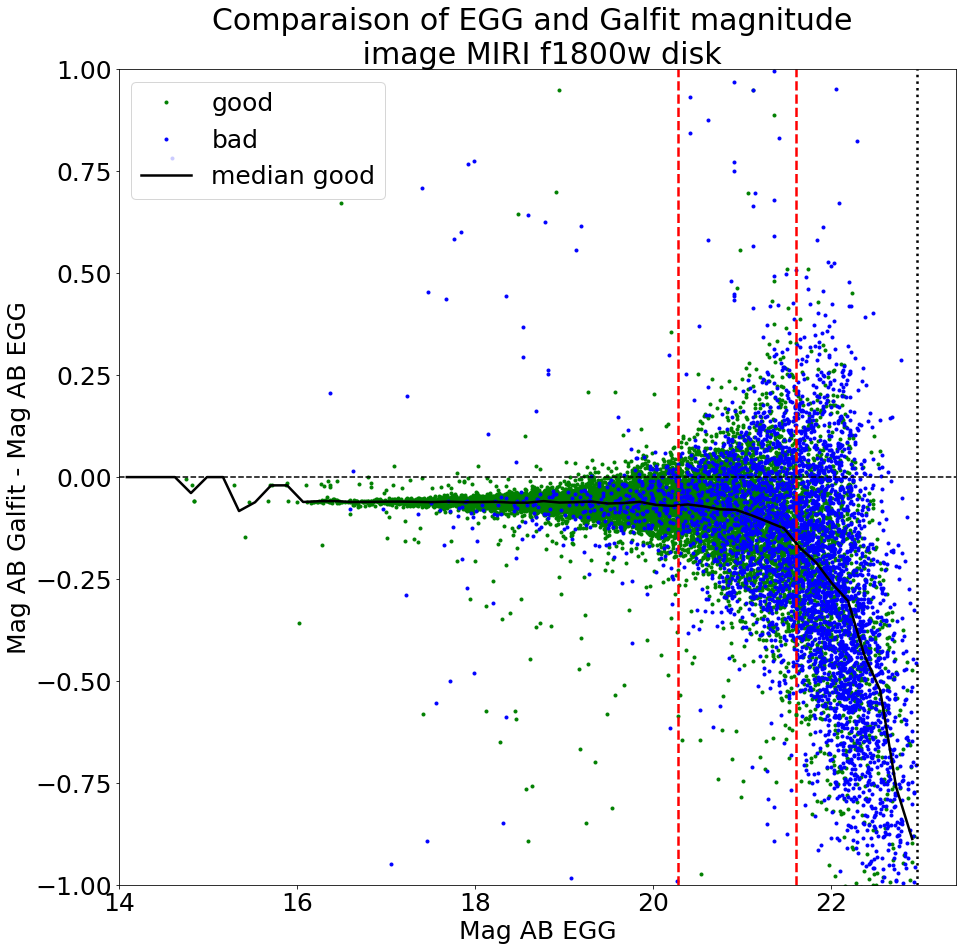

In [23]:
m_gal = np.array([])
m_gal_bn = np.array([])
mag_gs = np.array([])
mag_bn = np.array([])

for i in range(len(r_disk)):
    data_disk=ldata[i]
    m_gal=np.concatenate((m_gal,data_disk['MAG_GALFIT'][ok_all[i]][ngs[i]]))
    mag_gs=np.concatenate((mag_gs,mag[i][mag_detect[i]][cores_out_in_all[i][ok_all[i]]][ngs[i]]))
    
    m_gal_bn=np.concatenate((m_gal_bn,data_disk['MAG_GALFIT'][ok_all[i]][nbn[i]]))
    mag_bn=np.concatenate((mag_bn,mag[i][mag_detect[i]][cores_out_in_all[i][ok_all[i]]][nbn[i]]))

pe_re_g = m_gal-mag_gs
pe_re_b = m_gal_bn-mag_bn

re = []
mag_re=[]

bx=50

for j in range(bx) :
    
    minx= int(mag_gs.min())+( int(mag_gs.max()+1)-int(mag_gs.min())  )/bx*j
    maxx= int(mag_gs.min())+( int(mag_gs.max()+1)-int(mag_gs.min())  )/bx*(j+1)

    m_index,=np.where((mag_gs>minx) & (mag_gs<maxx))
    
    if len((m_gal[m_index]-mag_gs[m_index])) >=1 :
        re.append(np.median((m_gal[m_index]-mag_gs[m_index])))
    else :
        re.append(0)
    mag_re.append((minx+maxx)/2)

%matplotlib inline
plt.figure(figsize=(15,15))
plt.plot(mag_gs,pe_re_g,'g.',label='good')
plt.plot(mag_bn,pe_re_b,'b.',label='bad')
plt.plot(mag_re,re,'k-', label="median good", linewidth=2.5)

plt.axvline(x=22.96,color='k',linestyle=':', linewidth=2.5)
plt.axvline(x=21.61,color='r',linestyle='--', linewidth=2.5)
plt.axvline(x=20.28,color='r',linestyle='--', linewidth=2.5)
plt.axhline(y=0,color='k',linestyle='--', linewidth=1.5)

plt.xlabel('Mag AB EGG',fontsize=25)
plt.ylabel('Mag AB Galfit - Mag AB EGG', fontsize=25)
plt.title("Comparaison of EGG and Galfit magnitude \n image MIRI f1800w disk",fontsize=30)
plt.xlim(14,23.4)
plt.ylim(-1,1)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(loc='upper left',fontsize=25)
plt.show()

### Re

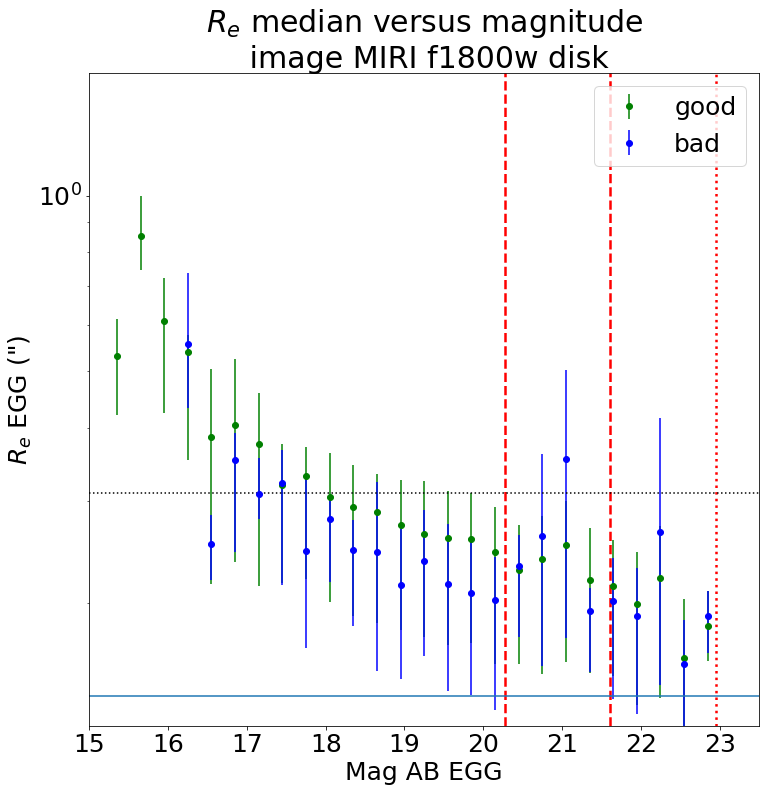

In [24]:
%matplotlib inline

re, re_b = [], []
low_err, high_err, low_err_b, high_err_b = [],[], [],[]
mag_re, mag_re_b =[], []

bx=30

r_d_all = np.array([])
mag_all = np.array([])

r_d_all_b = np.array([])
mag_all_b = np.array([])

for i in range(len(r_disk)):
    r_d_all=np.concatenate((r_d_all,r_disk[i][mag_detect[i]][cores_out_in_all[i]][gs[i]]/2))
    mag_all=np.concatenate((mag_all,mag[i][mag_detect[i]][cores_out_in_all[i]][gs[i]]))
    
    r_d_all_b=np.concatenate((r_d_all_b,r_disk[i][mag_detect[i]][cores_out_in_all[i]][bn[i]]/2))
    mag_all_b=np.concatenate((mag_all_b,mag[i][mag_detect[i]][cores_out_in_all[i]][bn[i]]))

for j in range(bx) :
    
    minx= int(mag_all.min())+( int(mag_all.max()+1)-int(mag_all.min())  )/bx*j
    maxx= int(mag_all.min())+( int(mag_all.max()+1)-int(mag_all.min())  )/bx*(j+1)

    m_index,=np.where((mag_all>minx) & (mag_all<maxx))
    
    if len(r_d_all[m_index]) >=1 :
        re.append(np.mean(r_d_all[m_index]))
        low_err.append(abs(np.mean(r_d_all[m_index])-np.quantile(r_d_all[m_index],0.25)))
        high_err.append(abs(np.mean(r_d_all[m_index])-np.quantile(r_d_all[m_index],0.75)))
    else :
        re.append(0)
        low_err.append(0)
        high_err.append(0)
    mag_re.append((minx+maxx)/2)
    
for j in range(bx) :
    
    minx= int(mag_all_b.min())+( int(mag_all_b.max()+1)-int(mag_all_b.min())  )/bx*j
    maxx= int(mag_all_b.min())+( int(mag_all_b.max()+1)-int(mag_all_b.min())  )/bx*(j+1)

    m_index,=np.where((mag_all_b>minx) & (mag_all_b<maxx))
    
    if len(r_d_all_b[m_index]) >=1 :
        re_b.append(np.mean(r_d_all_b[m_index]))
        low_err_b.append(abs(np.mean(r_d_all_b[m_index])-np.quantile(r_d_all_b[m_index],0.25)))
        high_err_b.append(abs(np.mean(r_d_all_b[m_index])-np.quantile(r_d_all_b[m_index],0.75)))
    else :
        re_b.append(0)
        low_err_b.append(0)
        high_err_b.append(0)
    mag_re_b.append((minx+maxx)/2)


errg = [low_err,high_err]
errs = [low_err_b,high_err_b]
fwhm=18/6e6/np.pi*180*3600
plt.figure(figsize=(12,12))
plt.errorbar(mag_re,re,yerr=errg,fmt="go",label="good")
plt.errorbar(mag_re_b,re_b,yerr=errs,fmt="bo",label="bad")
plt.axvline(x=22.96,color='r',linestyle=':', linewidth=2.5)
plt.axvline(x=21.61,color='r',linestyle='--', linewidth=2.5)
plt.axvline(x=20.28,color='r',linestyle='--', linewidth=2.5)
plt.axhline(y=fwhm/2,color='k',linestyle=':')
plt.axhline(y=pixel_scale)
plt.xlabel(r'Mag AB EGG',fontsize=25)
plt.ylabel(r'$R_e$ EGG (")', fontsize=25)
plt.title(r'$R_e$ median versus magnitude' + '\n image MIRI f1800w disk', fontsize=30)
plt.xlim(15,23.5)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(loc='upper right',fontsize=25)
#plt.ylim(5e-2,7e-1)
#plt.ylim(0,0.5)
plt.semilogy()
plt.show()

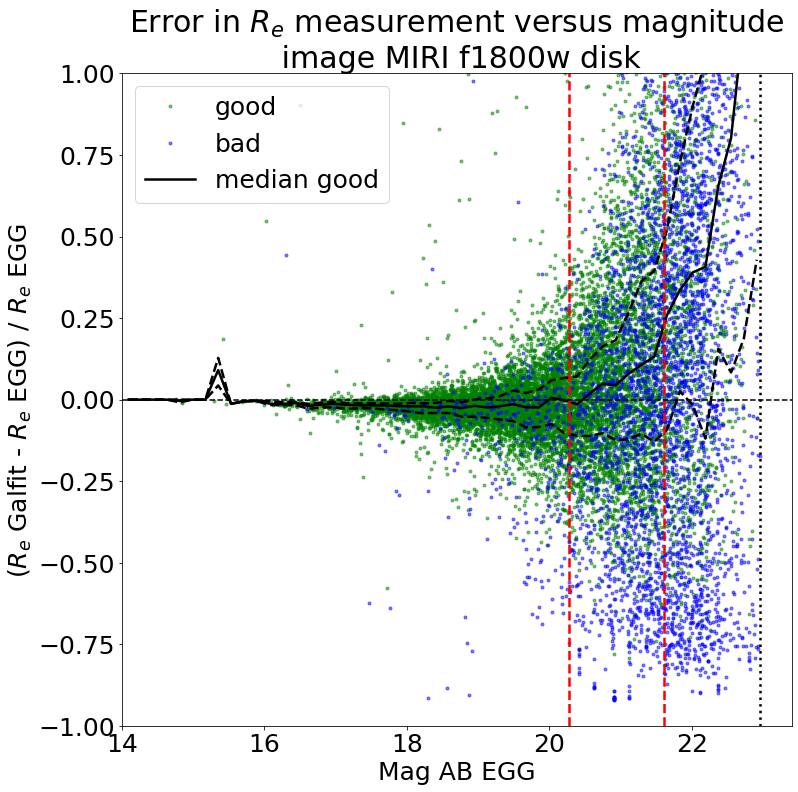

In [25]:
r_d_all = np.array([])
re_gal = np.array([])
re_gal_bn = np.array([])
r_d_all_bn = np.array([])
mag_gs = np.array([])
mag_bn = np.array([])

for i in range(len(r_disk)):
    data_disk=ldata[i]
    r_d_all=np.concatenate((r_d_all,r_disk[i][mag_detect[i]][cores_out_in_all[i][ok_all[i]]][ngs[i]]/2))
    re_gal=np.concatenate((re_gal,data_disk['RE_GALFIT'][ok_all[i]][ngs[i]]*pixel_scale))
    mag_gs=np.concatenate((mag_gs,mag[i][mag_detect[i]][cores_out_in_all[i][ok_all[i]]][ngs[i]]))
    
    r_d_all_bn=np.concatenate((r_d_all_bn,r_disk[i][mag_detect[i]][cores_out_in_all[i][ok_all[i]]][nbn[i]]/2))
    re_gal_bn=np.concatenate((re_gal_bn,data_disk['RE_GALFIT'][ok_all[i]][nbn[i]]*pixel_scale))
    mag_bn=np.concatenate((mag_bn,mag[i][mag_detect[i]][cores_out_in_all[i][ok_all[i]]][nbn[i]]))

pe_re_g = (re_gal-r_d_all)/r_d_all
pe_re_b = (re_gal_bn-r_d_all_bn)/r_d_all_bn

re = []
mag_re=[]
low_err, high_err = [],[]

bx=50

for j in range(bx) :
    
    minx= int(mag_gs.min())+( int(mag_gs.max()+1)-int(mag_gs.min())  )/bx*j
    maxx= int(mag_gs.min())+( int(mag_gs.max()+1)-int(mag_gs.min())  )/bx*(j+1)

    m_index,=np.where((mag_gs>minx) & (mag_gs<maxx))
    
    if len((re_gal[m_index]-r_d_all[m_index])/r_d_all[m_index]) >=1 :
        re.append(np.median(((re_gal[m_index]-r_d_all[m_index])/r_d_all[m_index])))
        low_err.append(abs(np.median(((re_gal[m_index]-r_d_all[m_index])/r_d_all[m_index]))-np.quantile(((re_gal[m_index]-r_d_all[m_index])/r_d_all[m_index]),0.25)))
        high_err.append(abs(np.median(((re_gal[m_index]-r_d_all[m_index])/r_d_all[m_index]))-np.quantile(((re_gal[m_index]-r_d_all[m_index])/r_d_all[m_index]),0.7)))
    else :
        re.append(0)
        low_err.append(0)
        high_err.append(0)
    mag_re.append((minx+maxx)/2)

%matplotlib inline
plt.figure(figsize=(12,12))
plt.plot(mag_gs,pe_re_g,'g.',alpha=0.5,label='good')
plt.plot(mag_bn,pe_re_b,'b.',alpha=0.5,label='bad')
plt.plot(mag_re,re,'k-', label="median good", linewidth=2.5)
plt.plot(mag_re,np.array(re)-np.array(low_err),'k--', linewidth=2.5)
plt.plot(mag_re,np.array(re)+np.array(high_err),'k--',linewidth=2.5)

plt.axvline(x=22.96,color='k',linestyle=':', linewidth=2.5)
plt.axvline(x=21.61,color='r',linestyle='--', linewidth=2.5)
plt.axvline(x=20.28,color='r',linestyle='--', linewidth=2.5)
plt.axhline(y=0,color='k',linestyle='--', linewidth=1.5)

plt.xlabel(r'Mag AB EGG',fontsize=25)
plt.ylabel(r'($R_e$ Galfit - $R_e$ EGG) / $R_e$ EGG', fontsize=25)
plt.title( r'Error in $R_e$ measurement versus magnitude' + '\n image MIRI f1800w disk', fontsize=30)
plt.xlim(14,23.4)
plt.ylim(-1,1)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(loc='upper left',fontsize=25)
plt.show()

### SFR 

In [23]:
bx=40 #bin x
by=40 #bin y
zb=[0,0.5,1,1.5,2.5,3.5,15]

imgz=[]
t, tQ, tSF = [], [], []
g, gQ, gSF = [], [], []


for k in trange(len(zb)-1):

    img=[]
    
    tot=np.zeros((bx,by))
    totQ=np.zeros((bx,by))
    totSF=np.zeros((bx,by))
    ntg=np.zeros((bx,by))
    ntgQ=np.zeros((bx,by))
    ntgSF=np.zeros((bx,by))

    for i in range(by) : 
        l=[]
        
        
        
        for j in range(bx) :
            
            
            # a fixer pour toutes les img
            zl = np.where((z[1][mag_detect[1]]>zb[k])&(z[1][mag_detect[1]]<zb[k+1]))[0]
            minx= int(m[1][mag_detect[1]][zl].min())+( int(m[1][mag_detect[1]][zl].max()+1)-int(m[1][mag_detect[1]][zl].min())  )/bx*j
            maxx= int(m[1][mag_detect[1]][zl].min())+( int(m[1][mag_detect[1]][zl].max()+1)-int(m[1][mag_detect[1]][zl].min())  )/bx*(j+1)
            miny= int(np.log10(sfr[1][mag_detect[1]][zl]).min()-1)+( int(np.log10(sfr[1][mag_detect[1]][zl]).max()+1)-int(np.log10(sfr[1][mag_detect[1]][zl]).min()-1 ) )/by*i
            maxy= int(np.log10(sfr[1][mag_detect[1]][zl]).min()-1)+( int(np.log10(sfr[1][mag_detect[1]][zl]).max()+1)-int(np.log10(sfr[1][mag_detect[1]][zl]).min()-1) )/by*(i+1)
            
            
            ntot = 0
            ntQ =  0
            ntSF = 0
            ngsT = 0
            ngsQT = 0
            ngsSFT = 0
            nbnT = 0
            nnfT = 0
            for d in range(len(ldata)) :
                #tot
                zl = np.where((z[d][mag_detect[d]]>zb[k])&(z[d][mag_detect[d]]<zb[k+1]))[0]
                ntot += np.where( (m[d][mag_detect[d]][zl]>minx) & (m[d][mag_detect[d]][zl]<maxx) & 
                                 (np.log10(sfr[d][mag_detect[d]][zl]) > miny) & (np.log10(sfr[d][mag_detect[d]][zl]) < maxy) )[0].shape[0]
                
                Q=np.where(q[d][mag_detect[d]][zl]==1)[0]
                ntQ += np.where( (m[d][mag_detect[d]][zl][Q]>minx) & (m[d][mag_detect[d]][zl][Q]<maxx) & 
                                 (np.log10(sfr[d][mag_detect[d]][zl][Q]) > miny) & (np.log10(sfr[d][mag_detect[d]][zl][Q]) < maxy) )[0].shape[0]
                
                Q=np.where(q[d][mag_detect[d]][zl]==0)[0]
                ntSF += np.where( (m[d][mag_detect[d]][zl][Q]>minx) & (m[d][mag_detect[d]][zl][Q]<maxx) & 
                                 (np.log10(sfr[d][mag_detect[d]][zl][Q]) > miny) & (np.log10(sfr[d][mag_detect[d]][zl][Q]) < maxy) )[0].shape[0]
                
                #good
                zl = np.where((z[d][mag_detect[d]][cores_out_in_all[d]][gs[d]]>zb[k])&(z[d][mag_detect[d]][cores_out_in_all[d]][gs[d]]<zb[k+1]))[0]
                ngsT += np.where( (m[d][mag_detect[d]][cores_out_in_all[d]][gs[d]][zl]>minx) & (m[d][mag_detect[d]][cores_out_in_all[d]][gs[d]][zl]<maxx) & 
                               (np.log10(sfr[d][mag_detect[d]][cores_out_in_all[d]][gs[d]][zl]) > miny) & (np.log10(sfr[d][mag_detect[d]][cores_out_in_all[d]][gs[d]][zl]) < maxy) )[0].shape[0]
                
                Q=np.where(q[d][mag_detect[d]][cores_out_in_all[d]][gs[d]][zl]==1)[0]
                ngsQT += np.where( (m[d][mag_detect[d]][cores_out_in_all[d]][gs[d]][zl][Q]>minx) & (m[d][mag_detect[d]][cores_out_in_all[d]][gs[d]][zl][Q]<maxx) & 
                               (np.log10(sfr[d][mag_detect[d]][cores_out_in_all[d]][gs[d]][zl][Q]) > miny) & (np.log10(sfr[d][mag_detect[d]][cores_out_in_all[d]][gs[d]][zl][Q]) < maxy) )[0].shape[0]
                
                Q=np.where(q[d][mag_detect[d]][cores_out_in_all[d]][gs[d]][zl]==0)[0]
                ngsSFT += np.where( (m[d][mag_detect[d]][cores_out_in_all[d]][gs[d]][zl][Q]>minx) & (m[d][mag_detect[d]][cores_out_in_all[d]][gs[d]][zl][Q]<maxx) & 
                               (np.log10(sfr[d][mag_detect[d]][cores_out_in_all[d]][gs[d]][zl][Q]) > miny) & (np.log10(sfr[d][mag_detect[d]][cores_out_in_all[d]][gs[d]][zl][Q]) < maxy) )[0].shape[0]
                
                #bad
                zl = np.where((z[d][mag_detect[d]][cores_out_in_all[d]][bn[d]]>zb[k])&(z[d][mag_detect[d]][cores_out_in_all[d]][bn[d]]<zb[k+1]))[0]
                nbnT += np.where( (m[d][mag_detect[d]][cores_out_in_all[d]][bn[d]][zl]>minx) & (m[d][mag_detect[d]][cores_out_in_all[d]][bn[d]][zl]<maxx) & 
                               (np.log10(sfr[d][mag_detect[d]][cores_out_in_all[d]][bn[d]][zl]) > miny) & (np.log10(sfr[d][mag_detect[d]][cores_out_in_all[d]][bn[d]][zl]) < maxy) )[0].shape[0]
                
                #non detect
                zl = np.where((z[d][mag_detect[d]][non_detct[d]]>zb[k])&(z[d][mag_detect[d]][non_detct[d]]<zb[k+1]))[0]
                nnfT += np.where( (m[d][mag_detect[d]][non_detct[d]][zl]>minx) & (m[d][mag_detect[d]][non_detct[d]][zl]<maxx) & 
                                (np.log10(sfr[d][mag_detect[d]][non_detct[d]][zl]) > miny) & (np.log10(sfr[d][mag_detect[d]][non_detct[d]][zl]) < maxy) )[0].shape[0]

                
            
            tot[i][j]=ntot
            totQ[i][j]=ntQ
            totSF[i][j]=ntSF

            if ntot ==0 :
                l.append([1.,1.,1.])
                
            else:
                ngs = ngsT/ntot
                ntg[i][j]=ngsT
                ntgQ[i][j]=ngsQT
                ntgSF[i][j]=ngsSFT
                nbn = nbnT/ntot
                nnf = nnfT/ntot
                
                l.append([nnf,ngs,nbn])
                
                

        img.append(l)
        
    t.append(tot)
    tQ.append(totQ)
    tSF.append(totSF)
    g.append(ntg)
    gQ.append(ntgQ)
    gSF.append(ntgSF)
    imgz.append(img)

  0%|          | 0/6 [00:00<?, ?it/s]

/tmp/ipykernel_103883/3408630467.py:14: RuntimeWarning: invalid value encountered in true_divide
  sfrg=np.sum(g[i],axis=0)/np.sum(t[i],axis=0)
/tmp/ipykernel_103883/3408630467.py:17: RuntimeWarning: invalid value encountered in true_divide
  sfrgQ=np.sum(gQ[i],axis=0)/np.sum(tQ[i],axis=0)
/tmp/ipykernel_103883/3408630467.py:20: RuntimeWarning: invalid value encountered in true_divide
  sfrgSF=np.sum(gSF[i],axis=0)/np.sum(tSF[i],axis=0)
/tmp/ipykernel_103883/3408630467.py:25: RuntimeWarning: invalid value encountered in true_divide
  mg=np.sum(gSF[i],axis=1)/np.sum(t[i],axis=1)


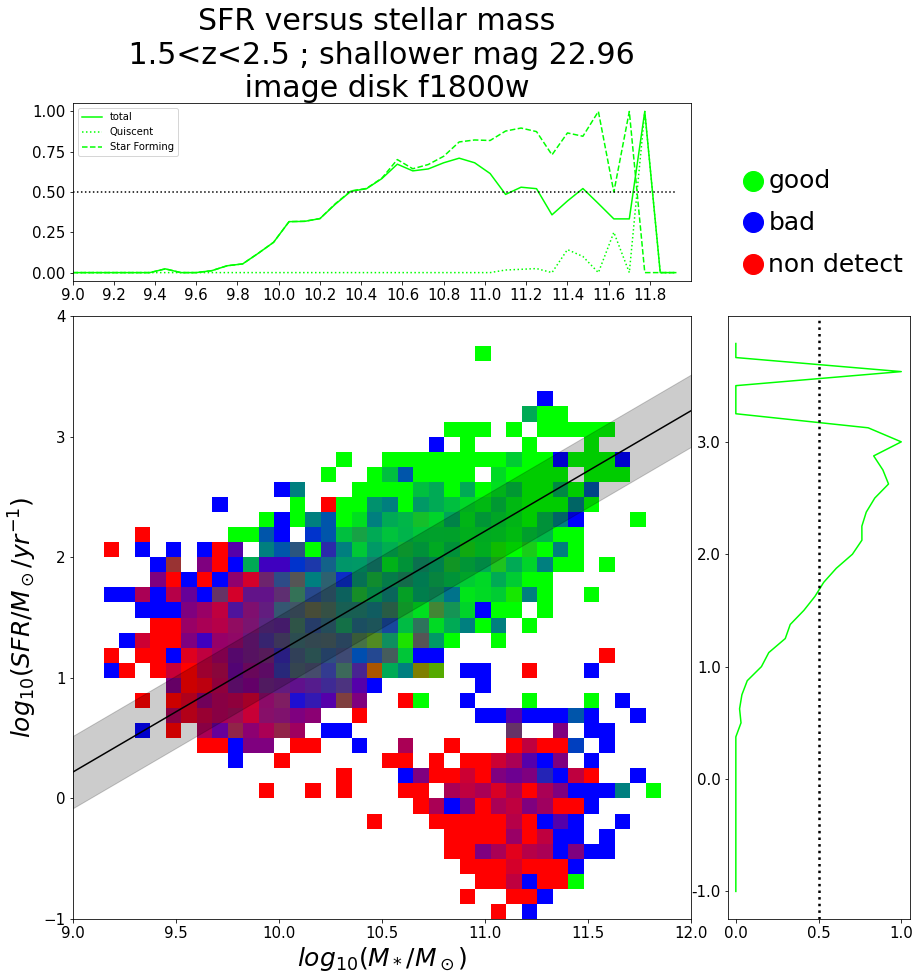

In [24]:
i=3

zl = np.where((z[1][mag_detect[1]]>zb[i])&(z[1][mag_detect[1]]<zb[i+1]))[0]
#ntx = int(m[1][mag_detect[1]][zl].max()+1)-int(m[1][mag_detect[1]][zl].min())
ntx = 2*int(m[1][mag_detect[1]][zl].max()+1)-int(m[1][mag_detect[1]][zl].min())
nx=np.arange(0,np.array(img).shape[0],np.array(img).shape[0]/ntx)
lx=np.around(np.arange(int(m[1][mag_detect[1]][zl].min()),int(m[1][mag_detect[1]][zl].max()+1),( int(m[1][mag_detect[1]][zl].max()+1)-int(m[1][mag_detect[1]][zl].min())  )/ntx),decimals=2)

nty = int(np.log10(sfr[1][mag_detect[1]][zl]).max()+1)-int(np.log10(sfr[1][mag_detect[1]][zl]).min()-1)
ny=np.arange(0,np.array(img).shape[1],np.array(img).shape[0]/nty)
ly=np.around(np.arange(int(np.log10(sfr[1][mag_detect[1]][zl]).min()-1),int(np.log10(sfr[1][mag_detect[1]][zl]).max()+1),( int(np.log10(sfr[1][mag_detect[1]][zl]).max()+1)-int(np.log10(sfr[1][mag_detect[1]][zl]).min()-1)  )/nty),decimals=2)


sfrg=np.sum(g[i],axis=0)/np.sum(t[i],axis=0)
sfrg[np.isnan(sfrg)]=0

sfrgQ=np.sum(gQ[i],axis=0)/np.sum(tQ[i],axis=0)
sfrgQ[np.isnan(sfrgQ)]=0

sfrgSF=np.sum(gSF[i],axis=0)/np.sum(tSF[i],axis=0)
sfrgSF[np.isnan(sfrgSF)]=0

x=np.arange(sfrg.shape[0])

mg=np.sum(gSF[i],axis=1)/np.sum(t[i],axis=1)
mg[np.isnan(mg)]=0
y=np.arange(mg.shape[0])


xMS = np.arange(int(m[1][mag_detect[1]][zl].min()),int(m[1][mag_detect[1]][zl].max()+1)+0.1,0.1)
logzMS = np.log10(1+(zb[i]+zb[i+1])/2)
yMS=xMS-9.5+1.5*logzMS-0.3*(max(0,xMS.any()-9.36-2.5*logzMS))**2
                    


fig=plt.figure(figsize=(15,15))
#fig.subplots_adjust(left=0.2, right=0.8, bottom=0.1, top=0.9)
axes=fig.subplot_mosaic(
    """
    aaal
    bbbc
    bbbc
    bbbc
    """)
axes['a'].set_title("SFR versus stellar mass \n {}<z<{} ; shallower mag 22.96 \n image disk f1800w".format(zb[i],zb[i+1]),fontsize=30)

axes['a'].plot(x,sfrg,color=(0,1,0),label='total')
axes['a'].plot(x,sfrgQ,':',color=(0,1,0),label='Quiscent')
axes['a'].plot(x,sfrgSF,'--',color=(0,1,0),label='Star Forming')
axes['a'].plot(x,np.ones(x.shape[0])*0.5,'k:')
axes['a'].set_xticks(nx,lx,fontsize=15)
axes['a'].set_xlim(0,sfrg.shape[0])
axes['a'].tick_params(axis='y', labelsize= 15)
#axes['a'].set_ylim(0,1.1)
axes['a'].legend()

axes['c'].plot(mg,y,color=(0,1,0))
axes['c'].set_yticks(ny,ly,fontsize=15)
axes['c'].tick_params(axis='x', labelsize= 15)
axes['c'].axvline(x=0.5,color='k',linestyle=':', linewidth=2.5)
#axes['c'].set_ylim(0,mg.shape[0])



axes['b'].imshow(imgz[i],origin='lower',
                 extent=[int(m[1][mag_detect[1]][zl].min()),int(m[1][mag_detect[1]][zl].max()+1),int(np.log10(sfr[1][mag_detect[1]][zl]).min()-1),int(np.log10(sfr[1][mag_detect[1]][zl]).max()+1)],
                 aspect='auto')
axes['b'].set_xlabel(r'$log_{10}(M_*/M_\odot)$',fontsize=25)
axes['b'].set_ylabel(r'$log_{10}(SFR/M_\odot/yr^{-1})$', fontsize=25)
axes['b'].tick_params(axis='x', labelsize= 15)
axes['b'].tick_params(axis='y', labelsize= 15)
axes['b'].plot(xMS,yMS,'k')
axes['b'].fill_between(xMS,yMS-0.3,yMS+0.3,color='k',alpha=0.2)

axes['l'].plot(0,2.15,'o',color=(0,1,0),ms=20,label='good')
axes['l'].plot(0,1.2,'bo',ms=20,label='bad')
axes['l'].plot(0,0.2,'ro',ms=20,label='non detect')
axes['l'].set_xlim(-0.008,0.05)
axes['l'].set_ylim(-0.2,4)
axes['l'].text(0.005,2,"good",fontsize=25)
axes['l'].text(0.005,1,"bad",fontsize=25)
axes['l'].text(0.005,0,"non detect",fontsize=25)
axes['l'].axis('off')

plt.show()